### Image processing series 4

MohammadAmin Baqeri
<br>
99222018

### Q1

In [25]:
import os
import cv2
import heapq
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable

In [26]:
def save(image: cv2.Mat, directory_path: str, file_name: str) -> None:
    if not os.path.exists(directory_path):
        os.makedirs(directory_path, exist_ok=True)
    
    cv2.imwrite(os.path.join(directory_path, file_name), image)

In [27]:
def show_image(image: cv2.Mat, title: str, cmap: str = "viridis", size: tuple = (11, 7)) -> None:
    plt.figure(figsize=size)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap=cmap)

In [28]:
def show_image_lst(image_lst: List[cv2.Mat], n_row: int, n_col: int, title: str,
               cmap: str = "viridis", size: tuple = (11, 7)) -> None:

    fig, axes = plt.subplots(n_row, n_col, figsize=size)
    fig.suptitle(title)

    row = 0
    col = 0
    for i in range(len(image_lst)):
        axes[row, col].imshow(image_lst[i], cmap=cmap)
        axes[row, col].axis("off")
        col += 1
        if col == n_col:
            col %= n_col 
            row += 1

In [29]:
gray1 = cv2.imread("files/series4/gray_scale/1.jpeg", cv2.IMREAD_GRAYSCALE)
gray2 = cv2.imread("files/series4/gray_scale/2.png", cv2.IMREAD_GRAYSCALE)
_, bi_image1 = cv2.threshold(cv2.imread("files/series4/binary/1.png", cv2.IMREAD_GRAYSCALE), 70 , 255, 0)
_, bi_image2 = cv2.threshold(cv2.imread("files/series4/binary/2.png", cv2.IMREAD_GRAYSCALE), 70 , 255, 0)
gray_scales = [gray1, gray2]
binary = [bi_image1, bi_image2]


In [30]:
def detecte_edges(image: cv2.Mat) -> cv2.Mat:
    blurred = cv2.medianBlur(image, 5)
    return cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 3)

In [31]:
def fill_holes(image: cv2.Mat) -> cv2.Mat:
    shape = image.shape
    output = np.full(shape, 255, dtype=np.uint8)
    for y in range(shape[0]):
        detecte_black = False
        for x in range(shape[1]-4):
            if not detecte_black:
                output[y, x] = 0

            if np.sum(image[y, x: x+4]) < 765:
                output[y, x] = 0
                if not detecte_black:
                    detecte_black = True
                else:
                    detecte_black = False
    return output

In [32]:
def fill_holes2(image: cv2.Mat) -> cv2.Mat:
    _, edge = cv2.threshold(image, 220, 255, cv2.THRESH_BINARY_INV); 
    shape = edge.shape
    im_fill = edge.copy()
    
    mask = np.zeros((shape[0]+2, shape[1]+2), np.uint8)
    cv2.floodFill(im_fill, mask, (0,0), 255);
    
    im_fill_inv = cv2.bitwise_not(im_fill)
    return edge | im_fill_inv

In [33]:
def log(image: cv2.Mat) -> cv2.Mat:
    output = cv2.GaussianBlur(image, (3, 3), 0)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    output = cv2.Laplacian(output, cv2.CV_16S, ksize=3)
    return cv2.convertScaleAbs(output)

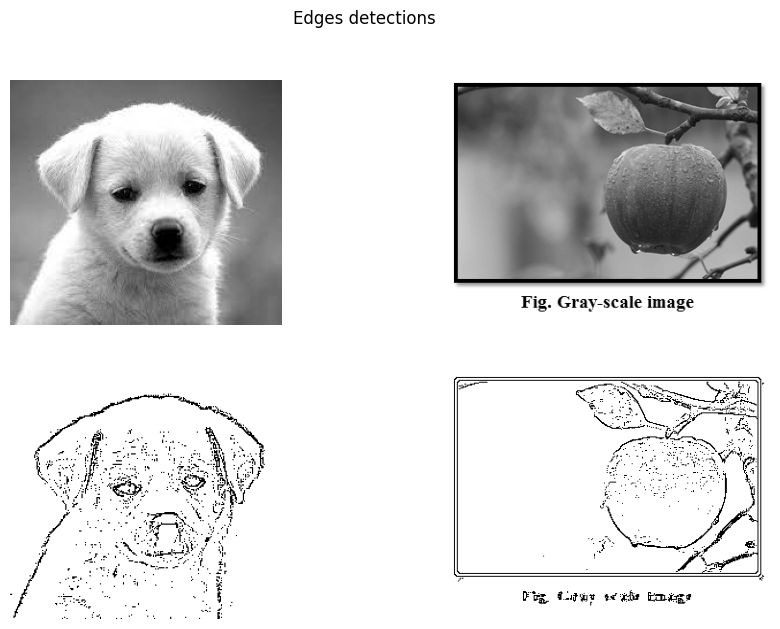

In [34]:
outputs = []
outputs.extend(gray_scales)
for image in gray_scales:
    outputs.append(detecte_edges(image))
show_image_lst(outputs, 2, 2, "Edges detections", "gray")

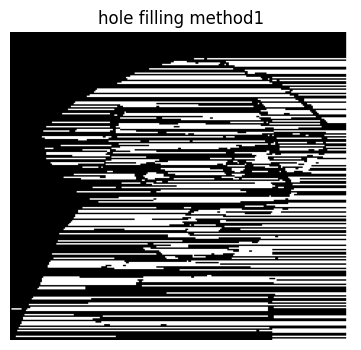

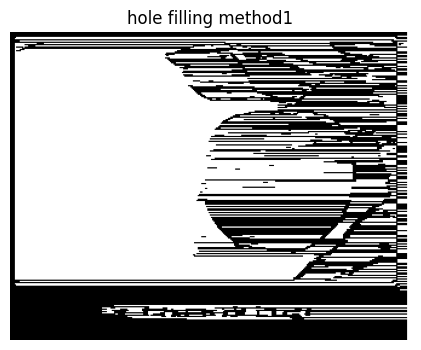

In [35]:
show_image(fill_holes(outputs[2]), "hole filling method1", cmap='gray', size=(7, 4))
show_image(fill_holes(outputs[3]), "hole filling method1", cmap='gray', size=(7, 4))

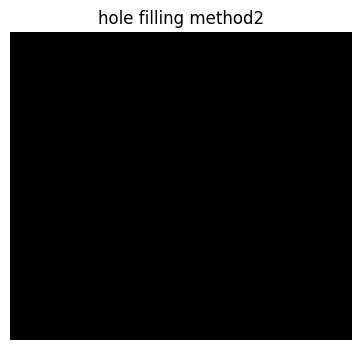

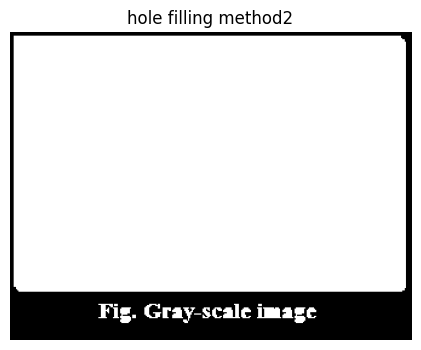

In [36]:
show_image(fill_holes2(outputs[0]), "hole filling method2", cmap='gray', size=(7, 4))
show_image(fill_holes2(outputs[1]), "hole filling method2", cmap='gray', size=(7, 4))

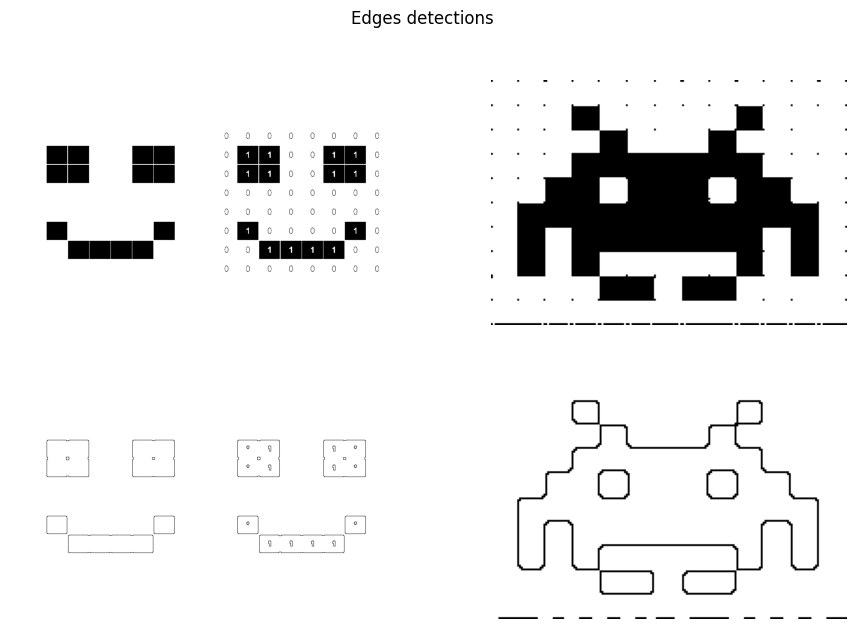

In [37]:
outputs = []
outputs.extend(binary)
for image in binary:
    outputs.append(detecte_edges(image))
show_image_lst(outputs, 2, 2, "Edges detections", "gray")

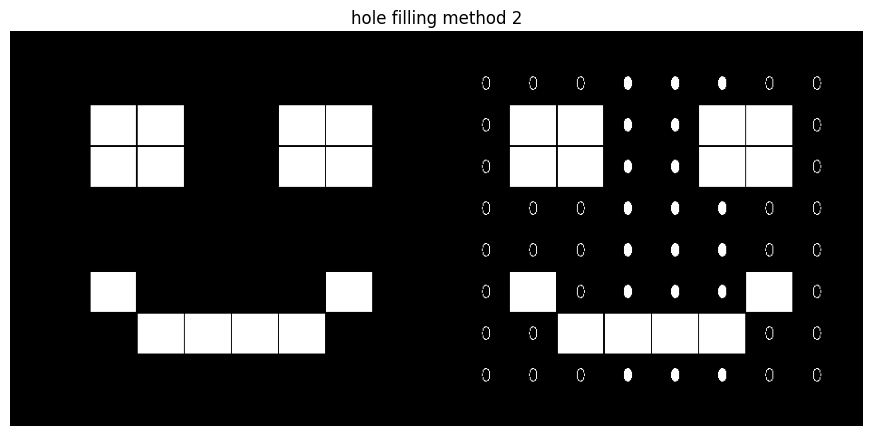

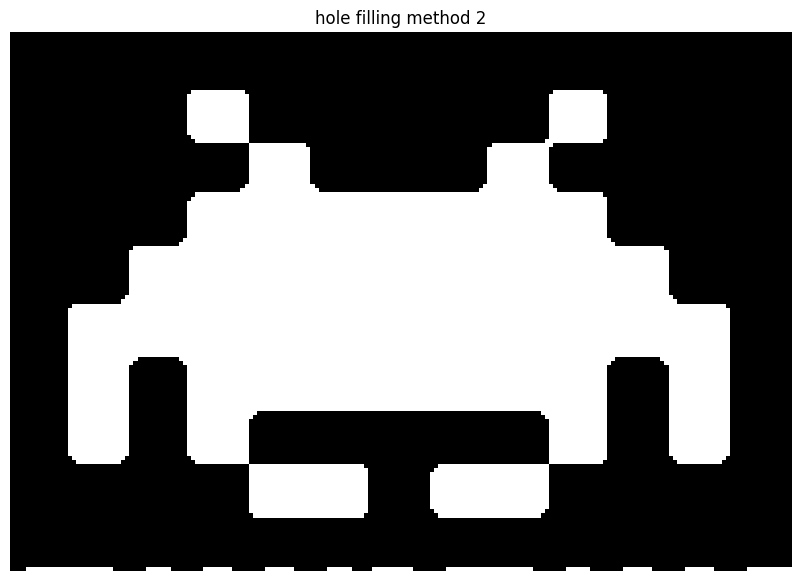

In [38]:
show_image(fill_holes2(outputs[0]), "hole filling method 2", cmap='gray')
show_image(fill_holes2(outputs[3]), "hole filling method 2", cmap='gray')

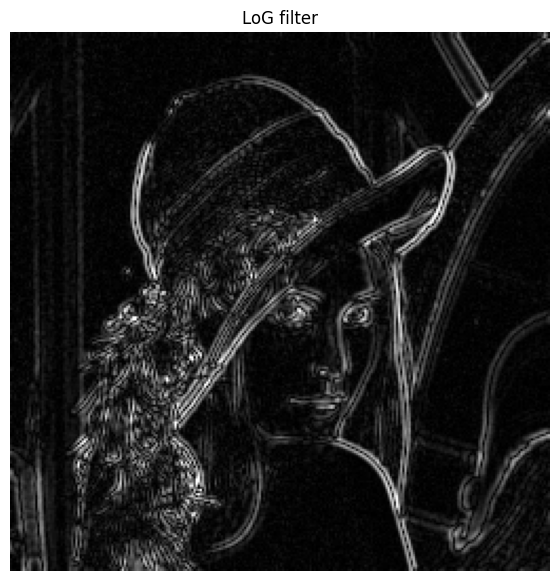

In [39]:
lena = cv2.imread("files/series4/gray_scale/lena.tif")
show_image(log(lena), "LoG filter", cmap="gray")

We can see that:
<br>
edges didn't detect correctly in gray scale images, so holes didn't fill
<br>
but in binary images edge detected better, so hole filling worked.

by using LOG filter edges can detected correctly so we can recognize objects easily

### Q2

In [40]:
def l2_overlap_diff(patch: np.ndarray, block_size: int, overlap: int, output_image: np.ndarray, y: int, x: int) -> int:
    error = 0
    if x > 0:
        left = patch[:, :overlap] - output_image[y: y+block_size, x: x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up = patch[:overlap, :] - output_image[y: y+overlap, x: x+block_size]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - output_image[y: y+overlap, x: x+overlap]
        error -= np.sum(corner**2)

    return error

In [41]:
def best_patch(texture: np.ndarray, texture_shape: Tuple[int, int, int], block_size: int, overlap: int, output_image: np.ndarray, y: int, x: int) -> np.ndarray:
    """Find the best patch with the minimum l2 difference"""

    if y == 0 and x == 0:
        y = random.randint(0, y+block_size-1)
        x = random.randint(0, x+block_size-1)
        return texture[y: y+block_size, x: x+block_size]

    pos_i, pos_j, min_error = None, None, np.Inf
    for i in range(texture_shape[0] - block_size):
        for j in range(texture_shape[1] - block_size):                
            patch = texture[i: i+block_size, j: j+block_size]
            e = l2_overlap_diff(patch, block_size, overlap, output_image, y, x)
            if e < min_error:
                min_error = e
                pos_i, pos_j = i, j

    return texture[pos_i: pos_i+block_size, pos_j: pos_j+block_size]


In [42]:
def min_cut_path(errors):
    pq = [(error, [i]) for i, error in enumerate(errors[0])]
    heapq.heapify(pq)

    h, w = errors.shape
    seen = set()

    while pq:
        error, path = heapq.heappop(pq)
        curDepth = len(path)
        curIndex = path[-1]

        if curDepth == h:
            return path

        for delta in -1, 0, 1:
            nextIndex = curIndex + delta

            if 0 <= nextIndex < w:
                if (curDepth, nextIndex) not in seen:
                    cumError = error + errors[curDepth, nextIndex]
                    heapq.heappush(pq, (cumError, path + [nextIndex]))
                    seen.add((curDepth, nextIndex))

In [43]:
def min_cut_patch(patch, overlap, res, y, x):
    patch = patch.copy()
    dy, dx, _ = patch.shape
    minCut = np.zeros_like(patch, dtype=bool)

    if x > 0:
        left = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        leftL2 = np.sum(left**2, axis=2)
        for i, j in enumerate(min_cut_path(leftL2)):
            minCut[i, :j] = True

    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        upL2 = np.sum(up**2, axis=2)
        for j, i in enumerate(min_cut_path(upL2.T)):
            minCut[:i, j] = True

    np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut)

    return patch

In [44]:
def synthesize(image_path: str, block_size: int, num_block: Tuple[int, int]) -> cv2.Mat:
    """Synthesize a texture"""
    
    image = np.divide(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB), 255)
    image_shape = image.shape
    overlap = block_size // 6
    num_blockHigh, num_blockWide = num_block

    h = (num_blockHigh * block_size) - (num_blockHigh - 1) * overlap
    w = (num_blockWide * block_size) - (num_blockWide - 1) * overlap
    output = np.zeros((h, w, image_shape[2]))

    pbar = tqdm(total=num_blockHigh*num_blockWide)
    for i in range(num_blockHigh):
        y = i * (block_size - overlap)
        for j in range(num_blockWide):
            x = j * (block_size - overlap)

            patch = best_patch(image, image_shape, block_size, overlap, output, y, x)
            patch = min_cut_patch(patch, overlap, output, y, x)

            output[y:y+block_size, x:x+block_size] = patch
            pbar.update(1)

    return output

  0%|          | 0/81 [00:00<?, ?it/s]

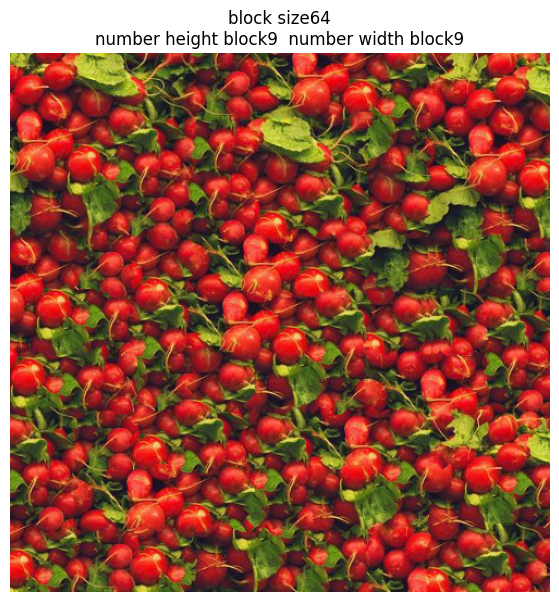

In [45]:
output = synthesize("files/series4/1.png", 64, (9, 9))
save(output, "files/series4/synthesized", "synthesized1.png")
show_image(output, f"block size{64}\nnumber height block{9}  number width block{9}")

  0%|          | 0/81 [00:00<?, ?it/s]

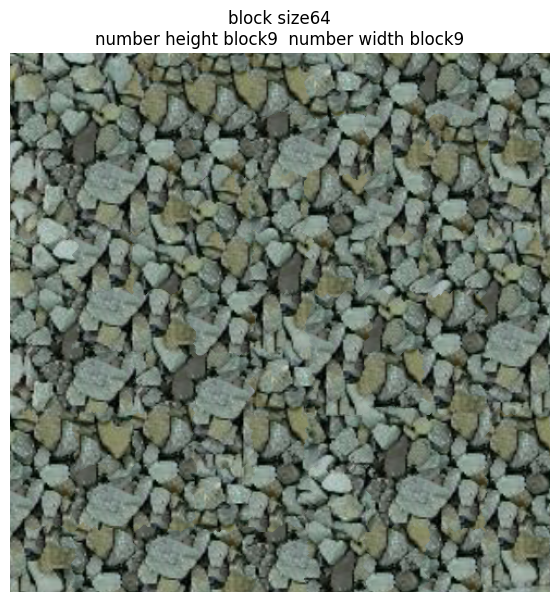

In [46]:
output = synthesize("files/series4/2.png", 64, (9, 9))
save(output, "files/series4/synthesized", "synthesized2.png")
show_image(output, f"block size{64}\nnumber height block{9}  number width block{9}")

  0%|          | 0/81 [00:00<?, ?it/s]

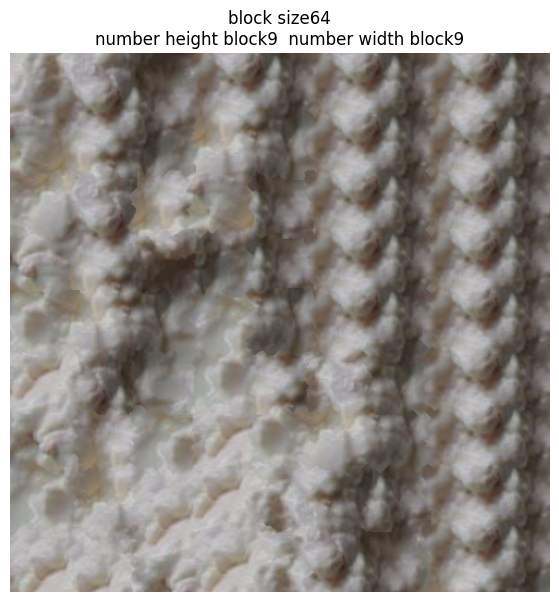

In [47]:
output = synthesize("files/series4/3.png", 64, (9, 9))
save(output, "files/series4/synthesized", "synthesized3.png")
show_image(output, f"block size{64}\nnumber height block{9}  number width block{9}")

  0%|          | 0/121 [00:00<?, ?it/s]

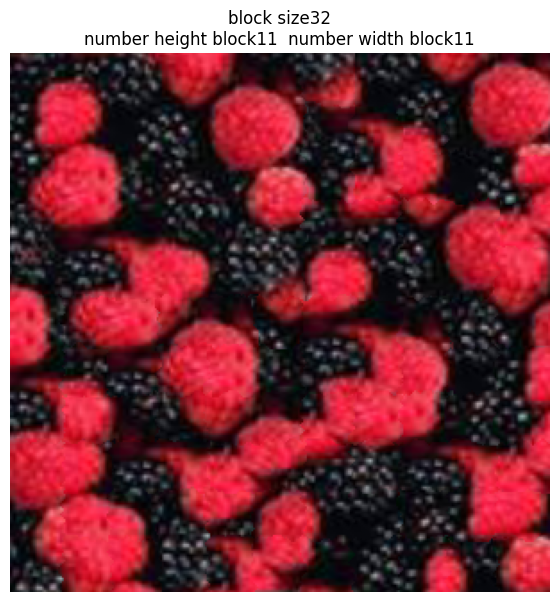

In [48]:
output = synthesize("files/series4/4.png", 32, (11, 11))
save(output, "files/series4/synthesized", "synthesized4.png")
show_image(output, f"block size{32}\nnumber height block{11}  number width block{11}")